In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

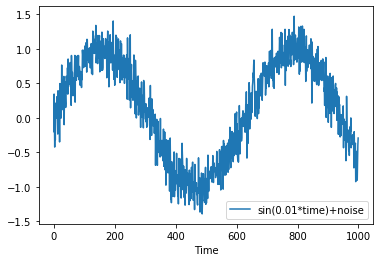

In [2]:
T = 1000
time = torch.arange(0.0, T)
X = torch.sin(0.01 * time) + 0.2 * torch.randn(T)
plt.plot(time.numpy(), X.numpy(), label="sin(0.01*time)+noise");
plt.legend();
plt.xlabel("Time");
plt.show()

In [3]:
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

#Hyperparameter
batch_size, train_number = 16, 600

#timestamp
tau = 4
features  = torch.zeros((T-tau, tau))

for i in range(tau):
    features[:,i] = X[i:(T-tau + i)]
labels = X[tau:]

train_dataset = TensorDataset(features[:train_number, :], labels[:train_number])
test_dataset = TensorDataset(features[train_number:,:], labels[train_number:])

In [4]:
import torch.nn as nn
# import tqdm from tqdm 
def init_weight(map_):
    if type(map_) == nn.Linear:
        torch.nn.init.xavier_uniform_(map_.weight)
        
#Vanila MLP architecture

#RNN
rnn = nn.RNN(tau,1)

#LSTM
lstm = nn.LSTM(tau,1)

#GLU
glu = nn.GRU(tau,1)


#Least mean squares loss
criterion = nn.MSELoss()
optimizer = torch.optim.Adam

def train_net(net,data,crierion,epochs,lr_rate):
    optim = optimizer(net.parameters(),lr=lr_rate)
    data_iter = DataLoader(data, batch_size, shuffle=True)
    
    #start trainning 
    for epoch  in range(1, epochs+1):
        running_loss = 0.
        for x,y in data_iter:
            optim.zero_grad()
            output,hidden = net(x.unsqueeze(1))
            loss = criterion(output, y.reshape(-1,1))
            loss.backward()
            optim.step()
            running_loss += loss.item()
        if epoch % 50 == 0:
            print(f"epoch :{epoch },loss:{loss:.2f}")
    test_predict = test_dataset[:][0]
    test_predict,test_hidden= net(test_dataset[:][0].reshape(-1,1,4))
    test_label= test_dataset[:][1].reshape(-1,1)
    test_loss = criterion(test_predict, test_label)
    print(f"test loss:{test_loss.mean()}")
    return net


In [5]:
# net = rnn
net_rnn = train_net(rnn,train_dataset,criterion,300,0.001)
net_lstm = train_net(lstm,train_dataset,criterion,300,0.001)
net_glu = train_net(glu,train_dataset,criterion,300,0.001)

/opt/conda/lib/python3.6/site-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([16, 1])) that is different to the input size (torch.Size([16, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/conda/lib/python3.6/site-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([8, 1])) that is different to the input size (torch.Size([8, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


epoch :50,loss:0.79
epoch :100,loss:0.60
epoch :150,loss:0.46
epoch :200,loss:0.45
epoch :250,loss:0.52
epoch :300,loss:0.43
test loss:0.35855287313461304


/opt/conda/lib/python3.6/site-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([396, 1])) that is different to the input size (torch.Size([396, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


epoch :50,loss:0.49
epoch :100,loss:0.44
epoch :150,loss:0.51
epoch :200,loss:0.56
epoch :250,loss:0.46
epoch :300,loss:0.36
test loss:0.3936196267604828
epoch :50,loss:0.78
epoch :100,loss:0.52
epoch :150,loss:0.46
epoch :200,loss:0.65
epoch :250,loss:0.32
epoch :300,loss:0.33
test loss:0.5155895948410034


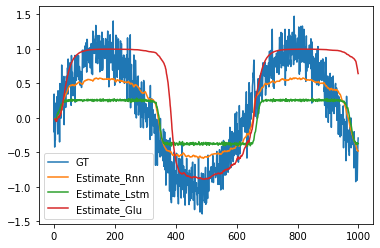

In [6]:
estimates_rnn,hidden_rnn = net_rnn(features.unsqueeze(1))
estimates_lstm,hidden_lstm = net_lstm(features.unsqueeze(1))
estimates_glu,hidden_glu = net_glu(features.unsqueeze(1))

plt.plot(time.numpy(),X.numpy(), label='GT')
plt.plot(time[tau:].numpy(), estimates_rnn[:,0].detach().numpy(), label = 'Estimate_Rnn')
plt.plot(time[tau:].numpy(), estimates_lstm[:,0].detach().numpy(), label = 'Estimate_Lstm')
plt.plot(time[tau:].numpy(), estimates_glu[:,0].detach().numpy(), label = 'Estimate_Glu')
plt.legend()

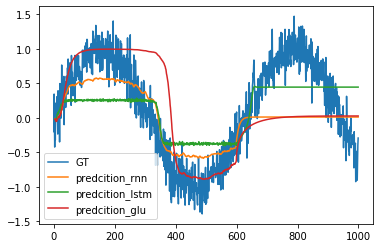

In [7]:
predictions_rnn = torch.zeros_like(estimates_rnn)
predictions_lstm = torch.zeros_like(estimates_rnn)
predictions_glu = torch.zeros_like(estimates_rnn)

predictions_rnn[:(train_number - tau)] = estimates_rnn[:(train_number - tau)]
predictions_lstm[:(train_number - tau)] = estimates_lstm[:(train_number - tau)]
predictions_glu[:(train_number - tau)] = estimates_glu[:(train_number - tau)]

for i in range((train_number - tau),(T-tau)):
    predictions_rnn[i]  = net_rnn(predictions_rnn[(i-tau):i].reshape(1,1,4))[0].float() * 10
    predictions_lstm[i] = net_lstm(predictions_lstm[(i-tau):i].reshape(1,1,4))[0].float() * 10
    predictions_glu[i]  = net_glu(predictions_glu[(i-tau):i].reshape(1,1,4))[0].float() * 10
    
plt.plot(time.numpy(), X.numpy(), label='GT')
plt.plot(time[tau:].numpy(), predictions_rnn[:,0].detach().numpy(), label='predcition_rnn')
plt.plot(time[tau:].numpy(), predictions_lstm[:,0].detach().numpy(), label='predcition_lstm')
plt.plot(time[tau:].numpy(), predictions_glu[:,0].detach().numpy(), label='predcition_glu')
plt.legend()

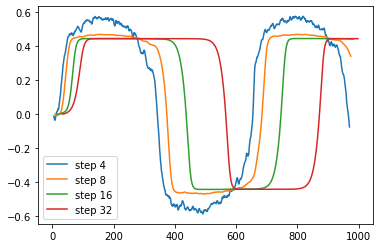

In [8]:
k = 33  # Look up to k - tau steps ahead
#rnn
features = torch.zeros((T-k, k))
for i in range(tau):
    features[:, i] = X[i:T-k+i]

for i in range(tau, k):
    features[:, i] = net_rnn(features[:,(i-tau):i].unsqueeze(1))[0].reshape((-1))
    
for i in (4, 8, 16, 32):
    plt.plot(time[i:T-k+i].numpy(), features[:, i].detach().numpy(),
             label=('step ' + str(i)))
plt.legend();

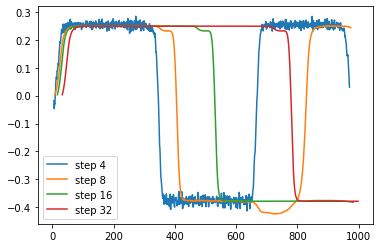

In [9]:
#LSTM
for i in range(tau, k):
    features[:, i] = net_lstm(features[:,(i-tau):i].unsqueeze(1))[0].reshape((-1))
    
for i in (4, 8, 16, 32):
    plt.plot(time[i:T-k+i].numpy(), features[:, i].detach().numpy(),
             label=('step ' + str(i)))
plt.legend();

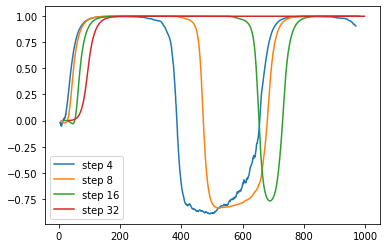

In [11]:
#GLU
for i in range(tau, k):
    features[:, i] = net_glu(features[:,(i-tau):i].unsqueeze(1))[0].reshape((-1))
    
for i in (4, 8, 16, 32):
    plt.plot(time[i:T-k+i].numpy(), features[:, i].detach().numpy(),
             label=('step ' + str(i)))
plt.legend();